In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import cv2
import time
import torch
import numpy as np
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from SimpleHRNet import SimpleHRNet
import warnings
from misc.visualization import draw_points_and_skeleton, joints_dict
import numpy as np
from fastdtw import fastdtw
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import scikit_posthocs as sp
import pandas as pd
from scipy.stats import kruskal
from PIL import Image
warnings.filterwarnings('ignore')

In [2]:
#load model 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleHRNet(32, 17, "./pose_hrnet_w32_256x192.pth", device=device, multiperson=False)

device: 'cuda' - 1 GPU(s) will be used


In [3]:
#video inferencing
def process_video(video_path):
    """
    Parameters:
    video_path (str): Path to the input video file.

    Returns:
    list: List of Coco-joint data for each frame in the video.
    """
    # List to store joints for each frame
    all_joints_truth = []

    # Open the video file
    video = cv2.VideoCapture(video_path)

    if not video.isOpened():
        print("Error: Could not open video.")
        return []

    # Get video properties
    fps = video.get(cv2.CAP_PROP_FPS)
    frame_width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Loop over video frames
    while True:
        t = time.time()
        ret, frame = video.read()
        if not ret:
            break  # End of video

        # Make predictions on the current frame
        joints = model.predict(frame) 
        all_joints_truth.append(joints[0])  # Store the joint data for this frame

        # Draw joints and skeleton on the frame (optional)
        pts = model.predict(frame)
        person_ids = np.arange(len(pts), dtype=np.int32)

        # Calculate and display framerate
        fps = 1. / (time.time() - t)
        print(f'\rFramerate: {fps:.2f} fps, for {len(pts)} person(s)', end='')
    print(" ")    
    # Release video capture
    video.release()

    cv2.destroyAllWindows()

    # Return the list of joints for each frame
    return all_joints_truth

In [4]:
# the list of exercise directories
exercise_directories = ['push_up', 'pull_up', 'squat', 'lunge']  

# the video names for each exercise
video_names = ['perfect.mp4', 'good_attempt.mp4', 'bad_attempt.mp4', 'almost.mp4']

# Initialize a dictionary to store the joint data for each exercise
all_joints = {}

# Loop through each exercise directory giving a dictionary of joint data for all exercises and all videos
for exercise in exercise_directories:
    # a list to store the joints for this exercise
    all_joints[exercise] = {}

    for video_name in video_names:
        # Construct the full path to the video
        video_path = os.path.join(exercise, video_name)
        print(f"Processing exercise: {exercise}, Video: {video_name}")
        # Check if the video exists 
        if os.path.exists(video_path):
            # Process the video and get the joint data using the model
            all_joints[exercise][video_name] = process_video(video_path)
        else:
            print(f"Warning: {video_path} does not exist. Skipping.")

Processing exercise: push_up, Video: perfect.mp4
Framerate: 7.70 fps, for 1 person(s) 
Processing exercise: push_up, Video: good_attempt.mp4
Framerate: 8.09 fps, for 1 person(s) 
Processing exercise: push_up, Video: bad_attempt.mp4
Framerate: 7.09 fps, for 1 person(s) 
Processing exercise: push_up, Video: almost.mp4
Framerate: 8.03 fps, for 1 person(s) 
Processing exercise: pull_up, Video: perfect.mp4
Framerate: 7.17 fps, for 1 person(s) 
Processing exercise: pull_up, Video: good_attempt.mp4
Framerate: 7.59 fps, for 1 person(s) 
Processing exercise: pull_up, Video: bad_attempt.mp4
Framerate: 8.46 fps, for 1 person(s) 
Processing exercise: pull_up, Video: almost.mp4
Framerate: 7.31 fps, for 1 person(s) 
Processing exercise: squat, Video: perfect.mp4
Framerate: 5.14 fps, for 1 person(s) 
Processing exercise: squat, Video: good_attempt.mp4
Framerate: 7.46 fps, for 1 person(s) 
Processing exercise: squat, Video: bad_attempt.mp4
Framerate: 7.92 fps, for 1 person(s) 
Processing exercise: squ

In [5]:
# Torso normalization
def normalize_pose_sequence(pose_sequence):
    normalized_sequence = []
    left_shoulder_idx = 5  # Left shoulder index in COCO format
    right_shoulder_idx = 6  # Right shoulder index in COCO format
    
    for frame in pose_sequence:
        # Get the coordinates of the left and right shoulders
        left_shoulder = frame[left_shoulder_idx, :2]  # Only x, y (ignore confidence)
        right_shoulder = frame[right_shoulder_idx, :2]  # Only x, y (ignore confidence)
        
        # Calculate the torso center (midpoint between the shoulders)
        torso_center_x = (left_shoulder[0] + right_shoulder[0]) / 2
        torso_center_y = (left_shoulder[1] + right_shoulder[1]) / 2
        
        # Normalize the joint positions relative to the torso center
        # Flatten the frame into a 1D vector: [joint1_x, joint1_y, joint2_x, joint2_y, ..., jointN_x, jointN_y]
        normalized_frame = []
        for joint in frame:
            normalized_frame.extend([joint[0] - torso_center_x, joint[1] - torso_center_y])  # Only x, y values
            
        normalized_sequence.append(normalized_frame)
    
    return normalized_sequence

In [6]:
# normalize all detected joints from inferencing phase using torso normalization
def process_and_normalize_all_joints(all_joints):
    normalized_all_joints = {}

    # Loop through each exercise in all_joints
    for exercise_name, video_data in all_joints.items():
        normalized_all_joints[exercise_name] = {}  # Initialize the dictionary for each exercise

        # Loop through each video within the exercise
        for video_name, pose_sequence in video_data.items():
            # Normalize the pose sequence for each video
            normalized_sequence = normalize_pose_sequence(pose_sequence)
            
            # Store the normalized sequence in the dictionary under the respective exercise and video
            normalized_all_joints[exercise_name][video_name] = normalized_sequence
            print(f"Normalized data for {exercise_name}/{video_name} added to dictionary.")

    return normalized_all_joints

In [7]:
# normalize and store the data in the dictionary
normalized_all_joints = process_and_normalize_all_joints(all_joints)

Normalized data for push_up/perfect.mp4 added to dictionary.
Normalized data for push_up/good_attempt.mp4 added to dictionary.
Normalized data for push_up/bad_attempt.mp4 added to dictionary.
Normalized data for push_up/almost.mp4 added to dictionary.
Normalized data for pull_up/perfect.mp4 added to dictionary.
Normalized data for pull_up/good_attempt.mp4 added to dictionary.
Normalized data for pull_up/bad_attempt.mp4 added to dictionary.
Normalized data for pull_up/almost.mp4 added to dictionary.
Normalized data for squat/perfect.mp4 added to dictionary.
Normalized data for squat/good_attempt.mp4 added to dictionary.
Normalized data for squat/bad_attempt.mp4 added to dictionary.
Normalized data for squat/almost.mp4 added to dictionary.
Normalized data for lunge/perfect.mp4 added to dictionary.
Normalized data for lunge/good_attempt.mp4 added to dictionary.
Normalized data for lunge/bad_attempt.mp4 added to dictionary.
Normalized data for lunge/almost.mp4 added to dictionary.


In [8]:
# Function to compute DTW distance between two sequences
def compute_dtw_distance(truth_sequence, attempt_sequence):
    distance, _ = fastdtw(truth_sequence, attempt_sequence, dist=euclidean)
    return distance

In [9]:
# Dictionary to store DTW distances for all exercises
dtw_results = {}

# Function to compute DTW distances for all videos in all exercises
def compute_dtw_for_all_exercises(normalized_all_joints):
    global dtw_results
    
    # Loop through each exercise in normalized_all_joints
    for exercise_name, video_data in normalized_all_joints.items():
        dtw_results[exercise_name] = {}  # Initialize the dictionary for each exercise
        
        # Extract the ground truth sequence for the exercise
        truth_sequence = video_data['perfect.mp4']  # perfect.mp4 is the ground truth
        
        # Compare with other videos (good attempt, bad attempt, almost perfect)
        for video_name in ['good_attempt.mp4', 'bad_attempt.mp4', 'almost.mp4']:  
            # Extract the sequence for the video
            attempt_sequence = video_data[video_name]
            
            # Compute the DTW distance between the ground truth and the attempt
            distance = compute_dtw_distance(truth_sequence, attempt_sequence)
            
            # Store the DTW distance in the dictionary
            dtw_results[exercise_name][video_name] = distance
            print(f"DTW Distance for {exercise_name} - {video_name}: {distance}")

In [10]:
# compute DTW distances for all exercises and videos
compute_dtw_for_all_exercises(normalized_all_joints)

DTW Distance for push_up - good_attempt.mp4: 46817.17204283547
DTW Distance for push_up - bad_attempt.mp4: 49166.85316382651
DTW Distance for push_up - almost.mp4: 23675.966910921994
DTW Distance for pull_up - good_attempt.mp4: 67925.70589349949
DTW Distance for pull_up - bad_attempt.mp4: 57822.53251176407
DTW Distance for pull_up - almost.mp4: 14650.76222715469
DTW Distance for squat - good_attempt.mp4: 33292.85688527379
DTW Distance for squat - bad_attempt.mp4: 62504.9073958209
DTW Distance for squat - almost.mp4: 39258.443642956845
DTW Distance for lunge - good_attempt.mp4: 58003.792650356
DTW Distance for lunge - bad_attempt.mp4: 196049.5929063609
DTW Distance for lunge - almost.mp4: 43534.182461710036


In [11]:
#Code for Resampling with DTW: function to interpolate sequences to the same length
def resample_sequence(sequence, target_length):
    original_length = len(sequence)
    x = np.linspace(0, 1, original_length)
    interpolator = interp1d(x, sequence, axis=0, kind='linear')
    new_x = np.linspace(0, 1, target_length)
    return interpolator(new_x)

In [12]:
# Dictionary to store resampled DTW distances for all exercises
dtw_results_resampled = {}

# Function to compute DTW distances for all videos in all exercises with resampling
def compute_dtw_for_all_exercises_with_resampling(normalized_all_joints):
    global dtw_results_resampled
    
    # Loop through each exercise in normalized_all_joints
    for exercise_name, video_data in normalized_all_joints.items():
        dtw_results_resampled[exercise_name] = {}  # Initialize the dictionary for each exercise
        
        # Extract the ground truth sequence for the exercise
        truth_sequence = video_data['perfect.mp4']  # perfect.mp4 is the ground truth
        
        # Compare with other videos (good attempt, bad attempt, almost perfect)
        for video_name in ['good_attempt.mp4', 'bad_attempt.mp4', 'almost.mp4']: 
            # Extract the sequence for the current video
            attempt_sequence = video_data[video_name]
            
            # Set the target length to the maximum length of the ground truth and attempt sequence
            target_length = max(len(truth_sequence), len(attempt_sequence))
            
            # Resample the ground truth sequence to the target length
            truth_sequence_resampled = resample_sequence(truth_sequence, target_length)
            
            # Resample the attempt sequence to the target length
            attempt_sequence_resampled = resample_sequence(attempt_sequence, target_length)
            
            # Compute the DTW distance between the resampled ground truth and the resampled attempt
            distance = compute_dtw_distance(truth_sequence_resampled, attempt_sequence_resampled)
            
            # Store the DTW distance in the dictionary
            dtw_results_resampled[exercise_name][video_name] = distance
            print(f"DTW Distance for {exercise_name} - {video_name} (Resampled): {distance}")


In [13]:
# compute resampled DTW distances for all exercises and videos
compute_dtw_for_all_exercises_with_resampling(normalized_all_joints)

DTW Distance for push_up - good_attempt.mp4 (Resampled): 48076.77123085852
DTW Distance for push_up - bad_attempt.mp4 (Resampled): 48751.3544832288
DTW Distance for push_up - almost.mp4 (Resampled): 24444.4025393939
DTW Distance for pull_up - good_attempt.mp4 (Resampled): 73363.07033201061
DTW Distance for pull_up - bad_attempt.mp4 (Resampled): 63502.39141639146
DTW Distance for pull_up - almost.mp4 (Resampled): 18420.73785101825
DTW Distance for squat - good_attempt.mp4 (Resampled): 38021.98501880126
DTW Distance for squat - bad_attempt.mp4 (Resampled): 63930.37974265927
DTW Distance for squat - almost.mp4 (Resampled): 41033.33508371606
DTW Distance for lunge - good_attempt.mp4 (Resampled): 65662.33396351873
DTW Distance for lunge - bad_attempt.mp4 (Resampled): 210101.66501096732
DTW Distance for lunge - almost.mp4 (Resampled): 49806.2968798793


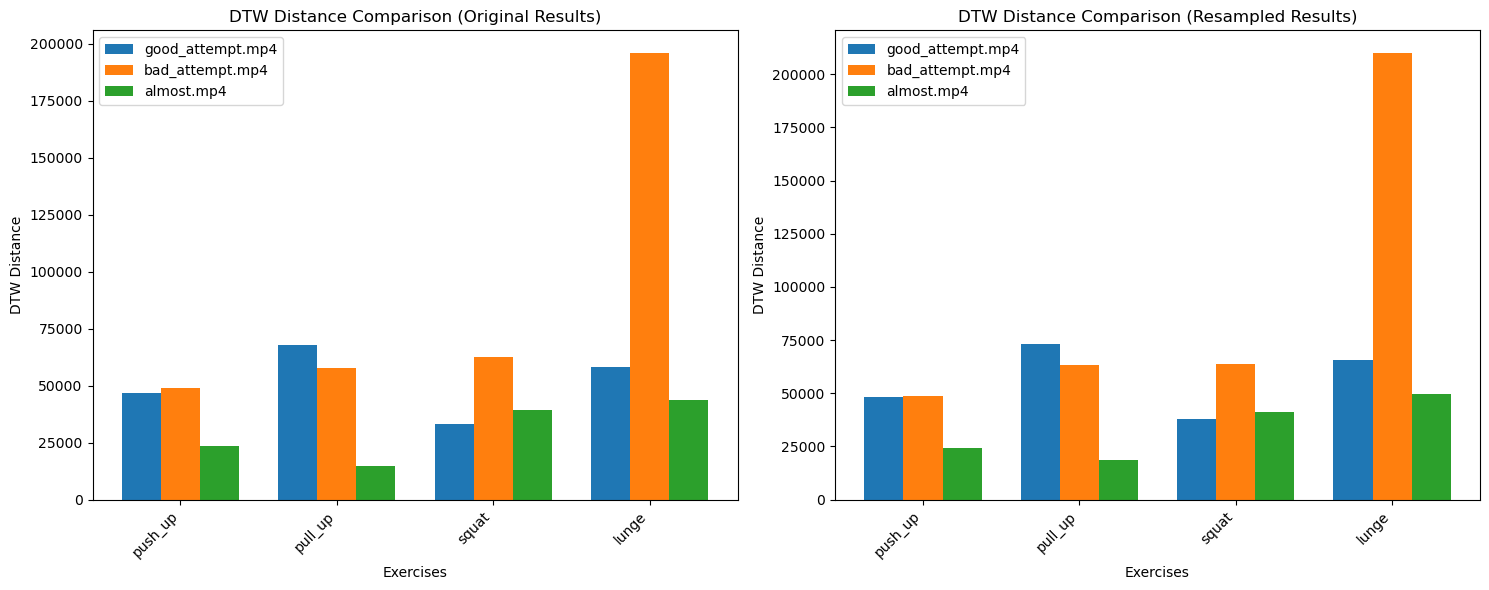

In [14]:
def visualize_dtw_results_side_by_side(dtw_results, dtw_results_resampled):
    # Extract exercises and their DTW distances
    exercises = list(dtw_results.keys())
    
    # a list of the video names
    video_names = ['good_attempt.mp4', 'bad_attempt.mp4', 'almost.mp4']
    
    # Prepare data for plotting
    distances_original = {video_name: [] for video_name in video_names}
    distances_resampled = {video_name: [] for video_name in video_names}
    
    for exercise in exercises:
        for video_name in video_names:
            distances_original[video_name].append(dtw_results[exercise].get(video_name, np.nan))
            distances_resampled[video_name].append(dtw_results_resampled[exercise].get(video_name, np.nan))
    
    # Create the figure with 2 subplots (side by side)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Bar width
    bar_width = 0.25
    index = np.arange(len(exercises))
    
    # Plot the original results 
    bars_original = []
    for i, video_name in enumerate(video_names):
        bars = ax1.bar(index + i * bar_width, distances_original[video_name], bar_width, label=video_name)
        bars_original.append(bars)
    
    ax1.set_xlabel('Exercises')
    ax1.set_ylabel('DTW Distance')
    ax1.set_title('DTW Distance Comparison (Original Results)')
    ax1.set_xticks(index + bar_width)
    ax1.set_xticklabels(exercises, rotation=45, ha='right')
    ax1.legend(handles=[bar[0] for bar in bars_original], labels=video_names)

    # Plot the resampled results 
    bars_resampled = []
    for i, video_name in enumerate(video_names):
        bars = ax2.bar(index + i * bar_width, distances_resampled[video_name], bar_width, label=video_name)
        bars_resampled.append(bars)
    
    ax2.set_xlabel('Exercises')
    ax2.set_ylabel('DTW Distance')
    ax2.set_title('DTW Distance Comparison (Resampled Results)')
    ax2.set_xticks(index + bar_width)
    ax2.set_xticklabels(exercises, rotation=45, ha='right')
    ax2.legend(handles=[bar[0] for bar in bars_resampled], labels=video_names)

    # Layout adjustment
    plt.tight_layout()
    plt.show()

visualize_dtw_results_side_by_side(dtw_results, dtw_results_resampled)

In [15]:
from scipy.stats import kruskal

# Initialize lists to collect DTW distances grouped by video type
good_attempts = []
bad_attempts = []
almost_attempts = []

# Loop through all exercises and collect distances
print("Collecting DTW distances per video type...\n")
for exercise_name, video_scores in dtw_results.items():
    print(f"Exercise: {exercise_name}")
    good = video_scores['good_attempt.mp4']
    bad = video_scores['bad_attempt.mp4']
    almost = video_scores['almost.mp4']

    print(f"  Good Attempt:   {good}")
    print(f"  Bad Attempt:    {bad}")
    print(f"  Almost Attempt: {almost}\n")

    good_attempts.append(good)
    bad_attempts.append(bad)
    almost_attempts.append(almost)

# Show all grouped DTW distances
print("Grouped DTW Distances:")
print(f"Good Attempts:   {good_attempts}")
print(f"Bad Attempts:    {bad_attempts}")
print(f"Almost Attempts: {almost_attempts}\n")

# Perform Kruskal-Wallis H-test
statistic, p_value = kruskal(good_attempts, bad_attempts, almost_attempts)

# Output results
print("Kruskal-Wallis H-test result:")
print(f"Statistic: {statistic}")
print(f"P-value: {p_value:.5f}")

if p_value < 0.05:
    print("✅ There is a statistically significant difference between at least two groups.")
else:
    print("❌ No statistically significant difference was found between the groups.")



Exercise: push_up
  Good Attempt:   46817.17204283547
  Bad Attempt:    49166.85316382651
  Almost Attempt: 23675.966910921994

Exercise: pull_up
  Good Attempt:   67925.70589349949
  Bad Attempt:    57822.53251176407
  Almost Attempt: 14650.76222715469

Exercise: squat
  Good Attempt:   33292.85688527379
  Bad Attempt:    62504.9073958209
  Almost Attempt: 39258.443642956845

Exercise: lunge
  Good Attempt:   58003.792650356
  Bad Attempt:    196049.5929063609
  Almost Attempt: 43534.182461710036

Grouped DTW Distances:
Good Attempts:   [46817.17204283547, 67925.70589349949, 33292.85688527379, 58003.792650356]
Bad Attempts:    [49166.85316382651, 57822.53251176407, 62504.9073958209, 196049.5929063609]
Almost Attempts: [23675.966910921994, 14650.76222715469, 39258.443642956845, 43534.182461710036]

Kruskal-Wallis H-test result:
Statistic: 6.269230769230774
P-value: 0.04352
✅ There is a statistically significant difference between at least two groups.


In [16]:
#Flatten DTW values and create corresponding group labels
dtw_values = []
group_labels = []

for exercise_name, video_scores in dtw_results.items():
    dtw_values.extend([
        video_scores['good_attempt.mp4'],
        video_scores['bad_attempt.mp4'],
        video_scores['almost.mp4']
    ])
    group_labels.extend([
        'Good Attempt',
        'Bad Attempt',
        'Almost Attempt'
    ])

# Create a DataFrame
df = pd.DataFrame({
    'dtw': dtw_values,
    'group': group_labels
})

# Run Dunn’s test using the correct DataFrame-based input
dunn_results = sp.posthoc_dunn(df, val_col='dtw', group_col='group', p_adjust='bonferroni')

# Display the results
print("Dunn's Post-hoc Test (with Bonferroni correction):")
print(dunn_results)


Dunn's Post-hoc Test (with Bonferroni correction):
                Almost Attempt  Bad Attempt  Good Attempt
Almost Attempt        1.000000     0.042684      0.286551
Bad Attempt           0.042684     1.000000      1.000000
Good Attempt          0.286551     1.000000      1.000000


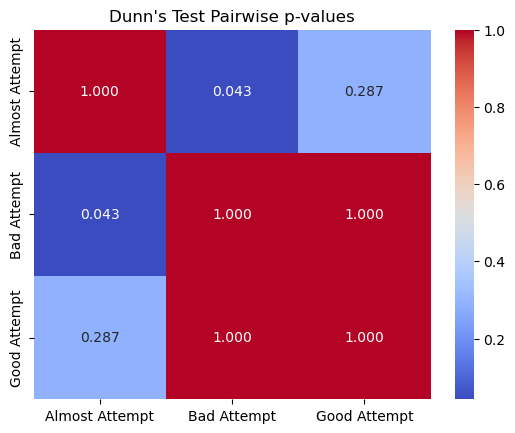

In [17]:
sns.heatmap(dunn_results, annot=True, cmap='coolwarm', fmt=".3f")
plt.title("Dunn's Test Pairwise p-values")
plt.show()

In [18]:
# Initialize lists to collect DTW distances grouped by video type
good_attempts = []
bad_attempts = []
almost_attempts = []

# Loop through all exercises and collect distances
for exercise_name, video_scores in dtw_results_resampled.items():
    good_attempts.append(video_scores['good_attempt.mp4'])
    bad_attempts.append(video_scores['bad_attempt.mp4'])
    almost_attempts.append(video_scores['almost.mp4'])

# Perform Kruskal-Wallis H-test
statistic, p_value = kruskal(good_attempts, bad_attempts, almost_attempts)

# Output results
print("Kruskal-Wallis H-test result:")
print(f"Statistic: {statistic}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("There is a statistically significant difference between at least two groups.")
else:
    print("No statistically significant difference was found between the groups.")

Kruskal-Wallis H-test result:
Statistic: 4.5
P-value: 0.10539922456186433
No statistically significant difference was found between the groups.
